
## Raceway_coal_burn_perce model for PDF shaping (894 samples)

This uses the new object oriented class for PDF shaping.

This model uses the CFD raceway data with 894 samples

## Web application 6 inputs and 1 output

Run interactively on the web at:

## Inputs

(1, 'i_h2_inj_kg_thm')

(2, 'i_pul_coal_inj_kg_thm')

(3, 'i_nat_gas_inj_kg_thm')

(4, 'i_nat_gas_t_k')

(5, 'i_o2_vol_perce')

(6, 'i_hot_blast_temp_k')

## Outputs

(11, 'o_raceway_coal_burn_perce')



## Imports


In [1]:

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch


import torch.optim as optim


from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)


In [3]:

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import onnxmltools
from onnxmltools.convert.xgboost.operator_converters.XGBoost import (
    convert_xgboost)
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster


from zipfile import ZipFile
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
    calculate_linear_regressor_output_shapes)


# Import the ONNX runtime environment
import onnxruntime as rt


In [4]:

import PDFshapingUtils as PDF_tk



## Instatiate PDF shaping and regression class


In [6]:

PDFshapingOBJ = PDF_tk.PDFshapingUtils()



## Initialize parameters


In [7]:

PDFshapingOBJ.N_error_range = 5         ## 20
PDFshapingOBJ.mean_impulse  = 0.0       ## -7.0      ## 0.0
PDFshapingOBJ.std_impulse   = 0.001     ## 1.0
PDFshapingOBJ.kde_std       = 0.5     ## 0.1       ## 0.5      ## 3.0  ## smaller is better approximation?
PDFshapingOBJ.bandwidth     = 0.2       ## 0.2->more jagged, 2.0->more smooth


In [8]:

PDFshapingOBJ.initializeImpulseGaussian()



## Run checks


In [9]:

## print(PDFshapingOBJ.x_range_impulse_func )
## print(PDFshapingOBJ.impulse_func_vector_vals )
## print(PDFshapingOBJ.quadratic_weights)
print(PDFshapingOBJ.x_range_impulse_func.shape )
print(PDFshapingOBJ.impulse_func_vector_vals.shape )
print(PDFshapingOBJ.quadratic_weights.shape)
 
print( sum(PDFshapingOBJ.impulse_func_vector_vals) )      ## should add up to 100 (i.e. 1.0 prob density)


torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
tensor(100.0000)


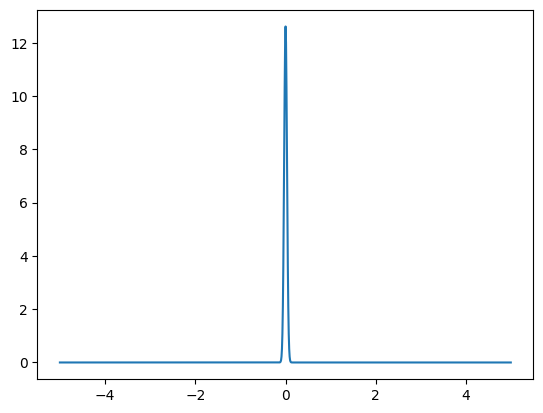

In [10]:

plt.plot(PDFshapingOBJ.x_range_impulse_func, PDFshapingOBJ.impulse_func_vector_vals)
plt.show()



## RUN KDE test


In [11]:

## PDFshapingOBJ.test_torchKDE_with_fake_data()



## Load Data


In [14]:

PDFshapingOBJ.read_csv_file_with_pandas('CFD.ForRelease.12.2023.csv')


In [15]:

PDFshapingOBJ.CFD_raw_data


,index,i_h2_inj_kg_thm,i_pul_coal_inj_kg_thm,i_nat_gas_inj_kg_thm,i_nat_gas_t_k,i_o2_vol_perce,i_hot_blast_temp_k,i_ore_moisture_weight_perce,i_ore_weight_kg,o_tuyere_exit_velo_m_s,...,o_shaft_co_utiliz,o_shaft_h2_utiliz,o_shaft_top_gas_temp_c,o_shaft_press_drop_pa,o_shaft_coke_rate_kg_thm,o_shaft_cohesive_zone_tip_height_m,o_shaft_co_v_perc,o_shaft_co2_v_perc,o_shaft_h2_v_perce,o_shaft_n2_v_perc
0,1,0.000000,0.0,0.1895,0.6,0.7,0.983042,0.777778,0.623735,133.48650,...,47.20085,42.99392,118.8785,108434.33,0.00000,31.83963,0.217192,0.194163,0.043833,0.544812
1,2,0.000000,0.0,0.1895,0.6,0.8,0.983042,0.777778,0.636403,133.09000,...,49.15851,44.99764,95.7563,108381.02,18.08450,31.83963,0.226098,0.218613,0.040343,0.514946
2,3,0.000000,0.0,0.1895,0.6,0.9,0.983042,0.777778,0.649070,132.77200,...,49.30602,44.48147,84.8519,112232.83,37.36395,31.75963,0.241959,0.235334,0.037726,0.484981
3,4,0.000000,0.0,0.1895,0.6,1.0,0.983042,0.777778,0.661738,132.33100,...,47.22992,46.37194,66.3779,118634.40,58.84995,31.55962,0.267702,0.239597,0.035448,0.457252
4,5,0.000000,0.0,0.3500,0.6,0.7,0.983042,0.777778,0.676050,135.09680,...,46.66340,41.83302,130.4139,106947.64,-40.16470,31.75963,0.211014,0.184613,0.071127,0.533246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,890,0.666667,0.0,0.3500,0.6,0.9,0.983042,0.777778,0.748919,152.86294,...,48.11546,42.78430,122.0079,137423.80,-41.14660,31.80024,0.213421,0.197917,0.122270,0.466392
890,891,1.000000,0.0,0.3000,0.6,0.9,0.983042,0.777778,0.756389,164.16174,...,47.40511,41.99833,132.4238,146622.00,-43.00085,31.88024,0.209051,0.188423,0.143751,0.458775
891,892,0.333333,0.0,0.5000,0.6,0.9,0.983042,0.777778,0.774045,149.15341,...,48.24004,41.11932,121.1668,128838.00,-53.28150,31.80024,0.216270,0.201562,0.117991,0.464177
892,893,0.666667,0.0,0.4500,0.6,0.9,0.983042,0.777778,0.781514,159.36325,...,47.21544,39.43614,129.2255,129115.30,-52.37820,31.76024,0.213118,0.190633,0.142068,0.454181


In [17]:

PDFshapingOBJ.print_headers_list()


['index', 'i_h2_inj_kg_thm', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_hot_blast_temp_k', 'i_ore_moisture_weight_perce', 'i_ore_weight_kg', 'o_tuyere_exit_velo_m_s', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
23
(0, 'index')
(1, 'i_h2_inj_kg_thm')
(2, 'i_pul_coal_inj_kg_thm')
(3, 'i_nat_gas_inj_kg_thm')
(4, 'i_nat_gas_t_k')
(5, 'i_o2_vol_perce')
(6, 'i_hot_blast_temp_k')
(7, 'i_ore_moisture_weight_perce')
(8, 'i_ore_weight_kg')
(9, 'o_tuyere_exit_velo_m_s')
(10, 'o_raceway_flame_temp_k')
(11, 'o_raceway_coal_burn_perce')
(12, 'o_raceway_volume_m')
(13, 'o_shaft_co_utiliz')
(14, 'o_shaft_h2_utiliz')
(15, 'o_shaft_top_gas_temp_c')
(16, 'o_shaft_press_drop_pa')
(17, 'o_s

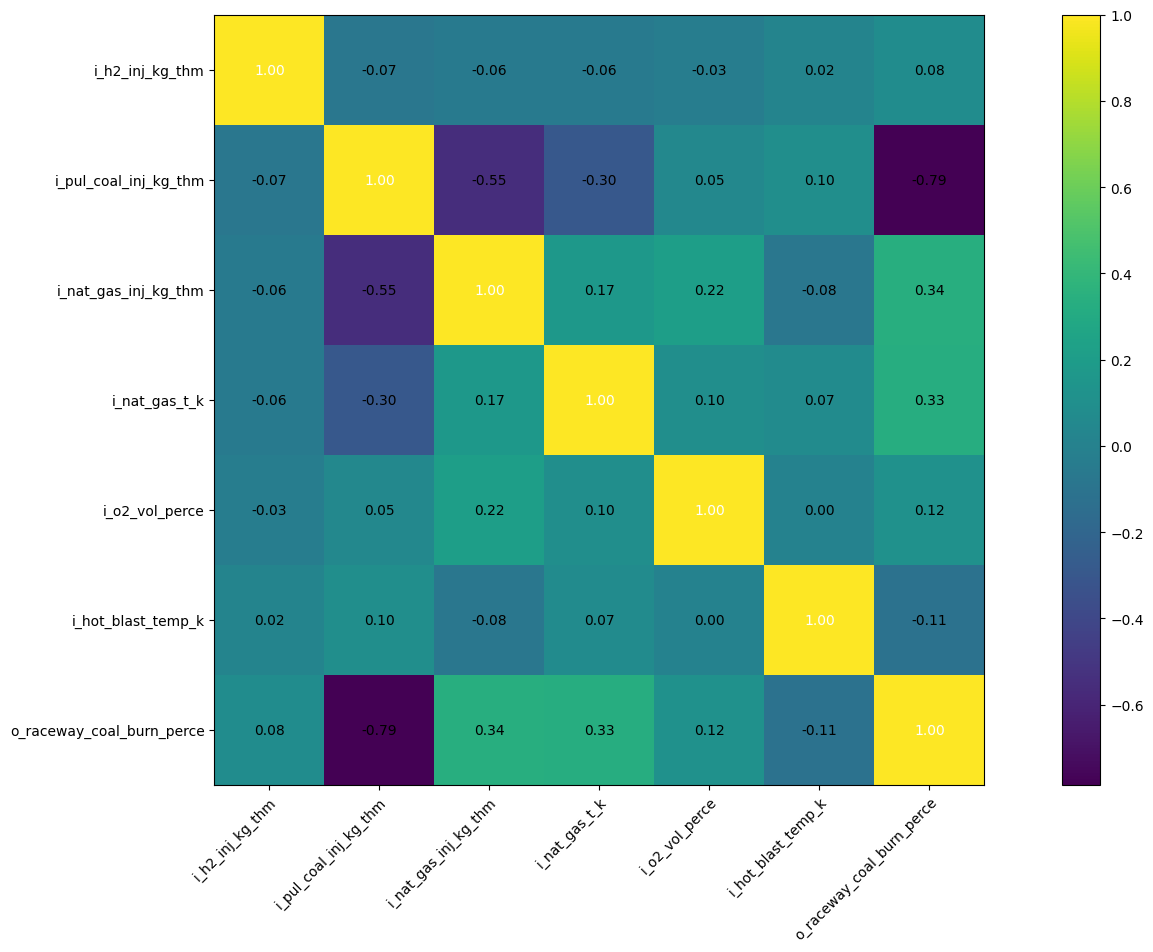

In [18]:

PDFshapingOBJ.list_of_selected_column_names = ['i_h2_inj_kg_thm', 'i_pul_coal_inj_kg_thm', 
                    'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_hot_blast_temp_k', 
                    'o_raceway_coal_burn_perce']

PDFshapingOBJ.print_correlation_coefficients()


In [19]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[  1.           0.           0.         ...   0.1941631    0.0438327
    0.5448123 ]
 [  2.           0.           0.         ...   0.2186134    0.04034286
    0.5149459 ]
 [  3.           0.           0.         ...   0.2353341    0.03772617
    0.4849808 ]
 ...
 [892.           0.33333333   0.         ...   0.2015624    0.1179911
    0.4641767 ]
 [893.           0.66666667   0.         ...   0.1906331    0.1420678
    0.4541806 ]
 [894.           1.           0.         ...   0.1820335    0.1569839
    0.4515486 ]]
(894, 23)



## Select inputs and outputs


In [20]:

PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs = [ 1, 2, 3, 4, 5, 6 ] , 
                   outputs= [ 11 ]   
)


6
1


In [21]:

print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)


(894, 6)
(894, 1)


In [22]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [23]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(715, 6)
(179, 6)
(715, 1)
(179, 1)


In [25]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [26]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [27]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl



## NN architectures


In [28]:

#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 1) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled


In [29]:

#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(6, 1)       
        
        ## F2
        self.f2_linear1 = nn.Linear(6, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 1)       
        self.f2_dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    



## Results for g(x) = F1(x) + F2(x) with No PDF shaping

F1 = Linear

F2 = Nonlinear


In [30]:

def fit_y_scaled(num_epochs, model, loss_fn, opt):
    
    PDFshapingOBJ.list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
            
            
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(
            torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()   )
            )
        )
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,           PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy()  ))
    


In [31]:

PDFshapingOBJ.the_string           = "No_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "raceway_coal_burn_perce"


0  loss=  tensor(1.8580, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.1984, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.0448, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.4839, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.1765, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.1350, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.1521, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.1168, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.0401, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.0487, grad_fn=<MseLossBackward0>)


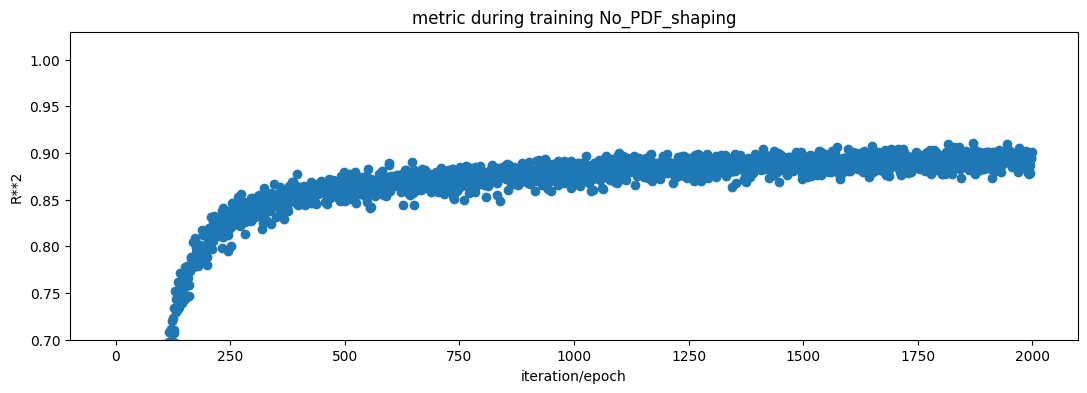

Training loss: tensor(0.0876, grad_fn=<MseLossBackward0>)
Training R**2: 0.9033912440127501
Test loss - scaled: tensor(0.0875, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(4.7460, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.8948975903378239
Testing R**2 - descaled: 0.8948976118805674
*****
*****
Testing R**2 - Output: 0 o_raceway_coal_burn_perce 0.8948976118805674


In [32]:

model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)

opt = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(PDFshapingOBJ.N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,         PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,       PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()    ))

PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


In [33]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])


**************************************************
preds, real
(80.494385, 82.30886)
**************************************************
preds, real
(99.66036, 100.0)
**************************************************
preds, real
(101.72376, 100.0)
**************************************************
preds, real
(99.33407, 100.0)
**************************************************
preds, real
(98.763725, 99.9007)
**************************************************
preds, real
(87.53307, 100.0)
**************************************************
preds, real
(84.00629, 82.934105)
**************************************************
preds, real
(99.57426, 100.0)
**************************************************
preds, real
(102.566765, 100.0)
**************************************************
preds, real
(101.559944, 100.0)
**************************************************
preds, real
(91.99197, 83.55645)
**************************************************
preds, real
(100.30795, 100.0)
********

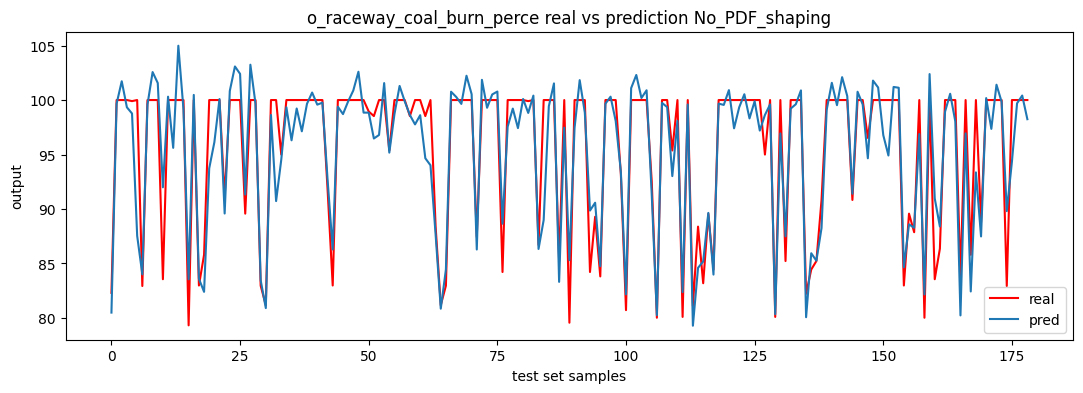

/Users/user/Desktop/DOE_CIVS/experiments/2023august/singleOutput/PDFshapingUtils.py:353: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


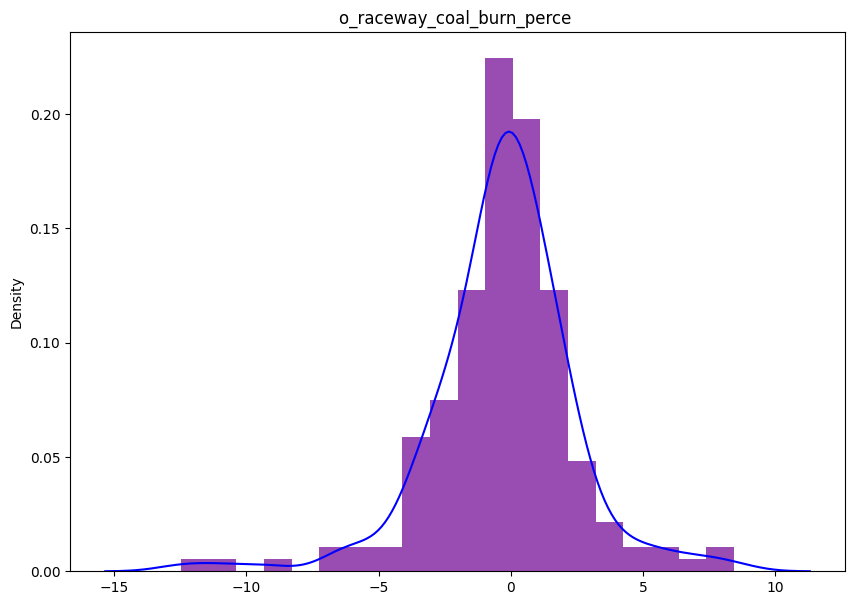

In [34]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )



## XGBoost


In [35]:

regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)


In [36]:

regressor.fit(PDFshapingOBJ.X_train, PDFshapingOBJ.y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [37]:

print( len(PDFshapingOBJ.X_train  ))
print( len(PDFshapingOBJ.y_train  ))


715
715


In [38]:

columns_thing = ['i_h2_inj_kg_thm', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 
                 'i_o2_vol_perce', 'i_hot_blast_temp_k', ]



pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns=columns_thing)


,i_h2_inj_kg_thm,i_pul_coal_inj_kg_thm,i_nat_gas_inj_kg_thm,i_nat_gas_t_k,i_o2_vol_perce,i_hot_blast_temp_k
0,0.000044,0.815687,0.13572,6.446197e-07,0.048548,0.0


In [39]:

y_pred = regressor.predict(PDFshapingOBJ.X_test )


In [40]:

y_pred


array([ 82.3056  , 100.00266 ,  99.981705,  99.997375,  99.977516,
       100.00413 ,  82.90371 ,  99.9964  ,  99.980606,  99.981705,
        83.56799 , 100.001595,  99.99747 ,  99.99844 ,  99.99552 ,
        79.32821 ,  99.99933 ,  82.96587 ,  85.80121 , 100.00035 ,
        99.9964  ,  99.99641 ,  91.021805, 100.00222 , 100.00413 ,
        99.9965  ,  89.66081 , 100.00144 ,  99.99844 ,  82.96227 ,
        81.17132 , 100.00155 , 100.00035 ,  95.1789  ,  99.99947 ,
        99.9965  ,  99.99432 ,  99.99539 ,  99.9974  , 100.00045 ,
        99.99933 , 100.00245 ,  91.87419 ,  82.96587 , 100.00245 ,
       100.01314 , 100.00045 , 100.00245 , 100.00787 ,  99.99928 ,
        98.88218 ,  98.37216 ,  99.9974  , 100.00266 ,  95.341286,
        99.99497 ,  99.981705, 100.00245 ,  98.37216 ,  99.9964  ,
       100.0094  ,  98.37216 , 100.00124 ,  88.41373 ,  81.17132 ,
        82.96227 , 100.006805,  99.9974  , 100.00266 , 100.00124 ,
        99.9974  ,  87.43671 ,  99.99844 ,  99.99552 ,  99.996

In [41]:

mean_squared_error(PDFshapingOBJ.y_test , y_pred)


0.0014381828

In [42]:

r2_score( PDFshapingOBJ.y_test, y_pred )


0.9999700625297074

In [43]:

len(y_pred)


179

In [44]:

list_preds = []
list_reals = []

print( "preds, real"   )
  
for j in range(   len(y_pred)    ):
    print(   y_pred[j], PDFshapingOBJ.y_test[j][0]   )
    
    list_preds.append(   y_pred[j]   )
    list_reals.append(  PDFshapingOBJ.y_test[j][0]   )


preds, real
82.3056 82.30886
100.00266 100.0
99.981705 100.0
99.997375 100.0
99.977516 99.9007
100.00413 100.0
82.90371 82.934105
99.9964 100.0
99.980606 100.0
99.981705 100.0
83.56799 83.55645
100.001595 100.0
99.99747 100.0
99.99844 100.0
99.99552 100.0
79.32821 79.32475
99.99933 100.0
82.96587 82.9805
85.80121 85.79921
100.00035 100.0
99.9964 100.0
99.99641 100.0
91.021805 91.07791
100.00222 100.0
100.00413 100.0
99.9965 100.0
89.66081 89.57585
100.00144 100.0
99.99844 100.0
82.96227 82.96335
81.17132 81.17173
100.00155 100.0
100.00035 100.0
95.1789 94.9968
99.99947 100.0
99.9965 100.0
99.99432 100.0
99.99539 100.0
99.9974 100.0
100.00045 100.0
99.99933 100.0
100.00245 100.0
91.87419 91.811264
82.96587 82.9805
100.00245 100.0
100.01314 100.0
100.00045 100.0
100.00245 100.0
100.00787 100.0
99.99928 100.0
98.88218 98.948135
98.37216 98.52782
99.9974 100.0
100.00266 100.0
95.341286 95.369934
99.99497 100.0
99.981705 100.0
100.00245 100.0
98.37216 98.52782
99.9964 100.0
100.0094 100.0
9

In [45]:

len( list_preds )


179

In [46]:
len( list_reals )

179

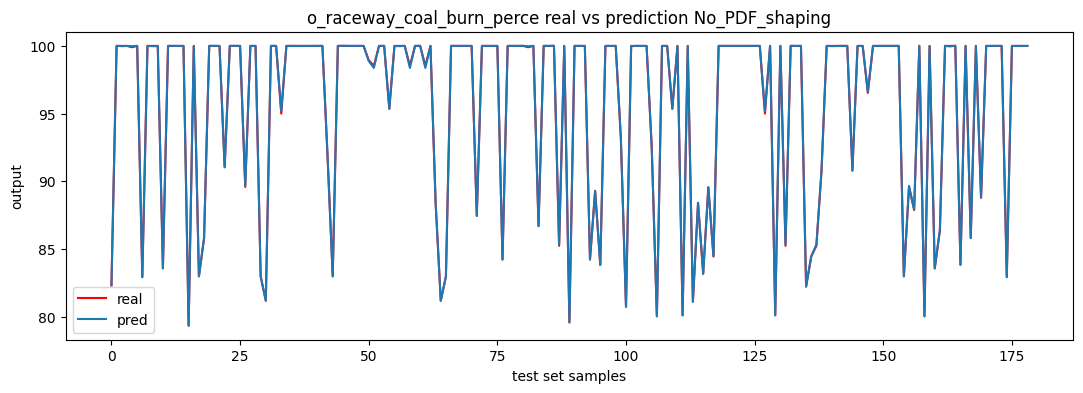

/Users/user/Desktop/DOE_CIVS/experiments/2023august/singleOutput/PDFshapingUtils.py:353: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


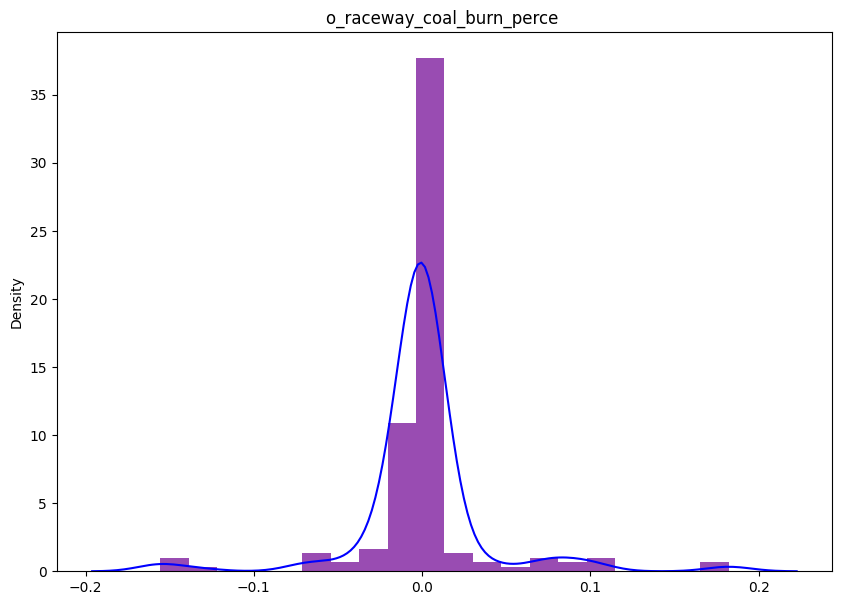

In [47]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )
